**Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

**Loading the data into dataframe**

In [ ]:
# Read the JSON files into DataFrames
embold_data = pd.read_json('/content/embold_train.json')
#df= pd.read_json('/content/embold_train_extra.json')

# Combine the two DataFrames
#embold_data = pd.concat([df1, df2], ignore_index=True)

# Randomly sample 15,000 rows from the combined DataFrame
#embold_data = combined_df.sample(n=150000, random_state=42)

In [ ]:
embold_data.head()

,title,body,label
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0


In [ ]:
embold_data.label.value_counts()

,count
label,
1,69106
0,66827
2,14067


## Text Preprocessing

In [ ]:
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Function to clean the text
def clean_text_embold(text_embold):
    text_embold = text_embold.lower()  # Convert to lowercase
    text_embold = re.sub(r'[^a-z\s]', '', text_embold)  # Remove special characters and numbers
    text_embold = re.sub(r'\s+', ' ', text_embold).strip()  # Remove extra spaces
    return text_embold

# Function to preprocess text (cleaning, tokenizing, and padding)
def preprocess_text_embold(text_embold, tokenizer_embold=None, max_length_embold=None, fit_tokenizer_embold=False):
    # Cleaning the text
    cleaned_text_embold = clean_text_embold(text_embold)

    # Tokenizer setup
    if fit_tokenizer_embold and tokenizer_embold is None:
        tokenizer_embold = Tokenizer()  # Initialize tokenizer if needed
        tokenizer_embold.fit_on_texts([cleaned_text_embold])

    # Tokenizing the text
    sequence_embold = tokenizer_embold.texts_to_sequences([cleaned_text_embold])

    # Determining max length
    if max_length_embold is None:
        max_length_embold = max(len(seq) for seq in sequence_embold)

    # Padding the sequence
    padded_sequence_embold = pad_sequences(sequence_embold, maxlen=max_length_embold, padding='post')

    return padded_sequence_embold, tokenizer_embold, max_length_embold


## Apply Preprocessing to the Training Data

In [ ]:
# `embold_data` is the training DataFrame with 'title' and 'body' columns
embold_data['text_embold'] = embold_data['title'] + ' ' + embold_data['body']
embold_data['cleaned_text_embold'] = embold_data['text_embold'].apply(clean_text_embold)

# Fitting the tokenizer on the cleaned training data
tokenizer_embold = Tokenizer()
tokenizer_embold.fit_on_texts(embold_data['cleaned_text_embold'])

# Converting text to sequences
sequences_embold = tokenizer_embold.texts_to_sequences(embold_data['cleaned_text_embold'])

# Determining maximum length for padding
max_length_embold = max(len(seq) for seq in sequences_embold)

# Padding sequences
padded_sequences_embold = pad_sequences(sequences_embold, maxlen=max_length_embold, padding='post')

# Extracting labels
labels_embold = embold_data['label'].values


In [ ]:
len(tokenizer_embold.word_index) + 1

1435207

## Building the RNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Defining the RNN model
model_embold = models.Sequential()
model_embold.add(layers.Embedding(
    input_dim=len(tokenizer_embold.word_index) + 1,
    output_dim=128,
    input_length=max_length_embold
))
model_embold.add(layers.SimpleRNN(64, return_sequences=False))
model_embold.add(layers.Dropout(0.5))
model_embold.add(layers.Dense(32, activation='relu'))
model_embold.add(layers.Dropout(0.5))
model_embold.add(layers.Dense(3, activation='softmax'))


model_embold.build(input_shape=(None, max_length_embold))

# Compiling the model
model_embold.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_embold.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 967, 128)            │      74,167,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,181,955 (282.98 MB)

 Trainable params: 74,181,955 (282.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split
padded_sequences_embold_subset = padded_sequences_embold[:100000]
labels_embold_subset = labels_embold[:100000]
# Split the data into training and validation sets
X_train_embold, X_val_embold, y_train_embold, y_val_embold = train_test_split(
    padded_sequences_embold_subset, labels_embold_subset, test_size=0.2, random_state=42,stratify=labels_embold_subset
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Fit the model
history_embold = model_embold.fit(
    X_train_embold, y_train_embold,
    validation_data=(X_val_embold, y_val_embold),
    epochs=5,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 415s 162ms/step - accuracy: 0.4521 - loss: 0.9757 - val_accuracy: 0.4753 - val_loss: 0.9416
Epoch 2/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 421s 155ms/step - accuracy: 0.4584 - loss: 0.9410 - val_accuracy: 0.4464 - val_loss: 0.9421
Epoch 3/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 395s 136ms/step - accuracy: 0.4563 - loss: 0.9406 - val_accuracy: 0.4604 - val_loss: 0.9383
Epoch 4/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 388s 139ms/step - accuracy: 0.4575 - loss: 0.9396 - val_accuracy: 0.4604 - val_loss: 0.9383
Epoch 5/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 357s 129ms/step - accuracy: 0.4613 - loss: 0.9374 - val_accuracy: 0.4604 - val_loss: 0.9382


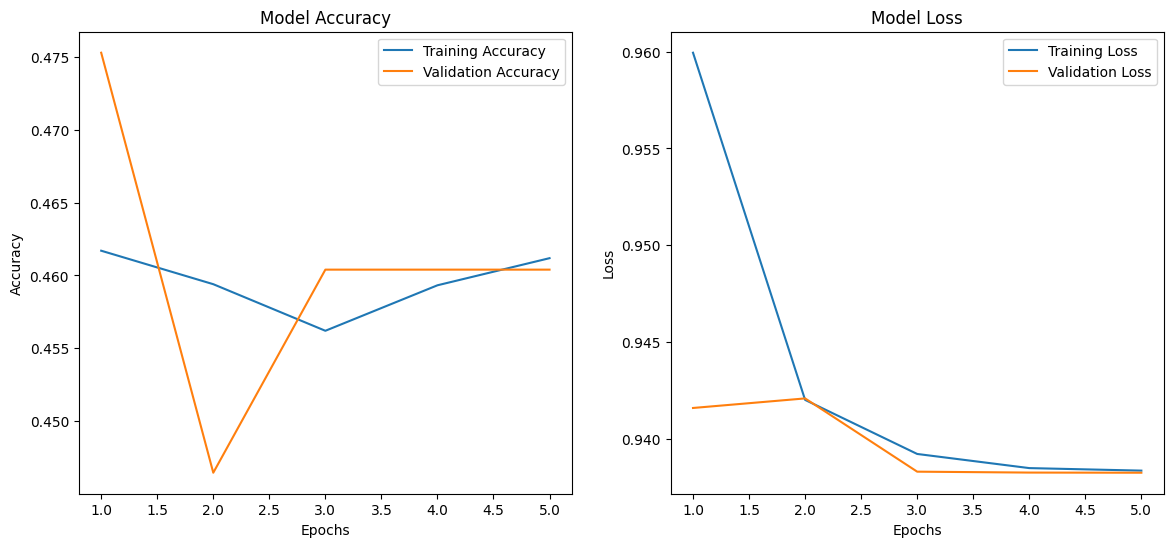

In [ ]:
import matplotlib.pyplot as plt

# Plotting the learning curves
def plot_learning_curves_embold(history_embold):
    # Extracting values from the training history
    accuracy_embold = history_embold.history['accuracy']
    val_accuracy_embold = history_embold.history['val_accuracy']
    loss_embold = history_embold.history['loss']
    val_loss_embold = history_embold.history['val_loss']
    epochs_embold = range(1, len(accuracy_embold) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_embold, accuracy_embold, label='Training Accuracy')
    plt.plot(epochs_embold, val_accuracy_embold, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_embold, loss_embold, label='Training Loss')
    plt.plot(epochs_embold, val_loss_embold, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot learning curves
plot_learning_curves_embold(history_embold)


## LSTM

In [ ]:
from tensorflow.keras import layers, models

model_embold_lstm = models.Sequential()
model_embold_lstm.add(layers.Embedding(
    input_dim=len(tokenizer_embold.word_index) + 1,
    output_dim=128,
    input_length=max_length_embold
))
model_embold_lstm.add(layers.LSTM(64, return_sequences=False))
model_embold_lstm.add(layers.Dropout(0.5))
model_embold_lstm.add(layers.Dense(32, activation='relu'))
model_embold_lstm.add(layers.Dropout(0.5))
model_embold_lstm.add(layers.Dense(3, activation='softmax'))

model_embold_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


In [ ]:
history_embold_lstm = model_embold_lstm.fit(
    X_train_embold, y_train_embold,
    validation_data=(X_val_embold, y_val_embold),
    epochs=5,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 218s 81ms/step - accuracy: 0.4584 - loss: 0.9520 - val_accuracy: 0.4604 - val_loss: 0.9383
Epoch 2/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 257s 82ms/step - accuracy: 0.4590 - loss: 0.9409 - val_accuracy: 0.4604 - val_loss: 0.9383
Epoch 3/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 262s 82ms/step - accuracy: 0.4565 - loss: 0.9390 - val_accuracy: 0.4604 - val_loss: 0.9385
Epoch 4/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 263s 82ms/step - accuracy: 0.4595 - loss: 0.9388 - val_accuracy: 0.4604 - val_loss: 0.9383


## BERT Transformer model

In [ ]:
pip install transformers


In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split

# Load the BERT tokenizer
tokenizer_embold = BertTokenizer.from_pretrained('bert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:


# Tokenize the text using the BERT tokenizer
def encode_texts(texts, tokenizer, max_length):
    return tokenizer(
        texts.tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

# Split the data into training and validation sets
X_train_embold, X_val_embold, y_train_embold, y_val_embold = train_test_split(
    embold_data['text_embold'][0:10000], embold_data['label'][0:10000], test_size=0.2, random_state=42
)

# Encode the text data
max_length_embold = 128
train_encodings = encode_texts(X_train_embold, tokenizer_embold, max_length_embold)
val_encodings = encode_texts(X_val_embold, tokenizer_embold, max_length_embold)


In [ ]:
# Loading the pre-trained BERT model for sequence classification
model_embold_bert = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Compiling the model
model_embold_bert.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training the model
history_embold_bert = model_embold_bert.fit(
    x={'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    y=y_train_embold,
    validation_data=(
        {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
        y_val_embold
    ),
    epochs=3,
    batch_size=16
)


Epoch 1/3
500/500 [==============================] - 272s 444ms/step - loss: 0.9929 - accuracy: 0.4541 - val_loss: 0.9817 - val_accuracy: 0.4500
Epoch 2/3
500/500 [==============================] - 218s 437ms/step - loss: 0.9990 - accuracy: 0.4539 - val_loss: 0.9369 - val_accuracy: 0.4500
Epoch 3/3
500/500 [==============================] - 218s 436ms/step - loss: 1.0083 - accuracy: 0.4577 - val_loss: 0.9498 - val_accuracy: 0.4500


## TF_IDF using Multi layer perceptron

In [ ]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import nltk

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
df_embold = pd.read_json('/content/embold_train.json')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Initialize stopwords and lemmatizer
stop_words_embold = set(stopwords.words('english'))
lemmatizer_embold = WordNetLemmatizer()

def clean_text_embold(text_embold):
    # Convert to lowercase
    text_embold = text_embold.lower()
    # Remove punctuation
    text_embold = re.sub(f"[{re.escape(string.punctuation)}]", " ", text_embold)
    # Remove extra spaces
    text_embold = re.sub(r'\s+', ' ', text_embold).strip()
    # Remove stopwords and apply lemmatization
    words_embold = [lemmatizer_embold.lemmatize(word) for word in text_embold.split() if word not in stop_words_embold]
    return ' '.join(words_embold)

# Apply cleaning to the body column
df_embold['cleaned_body_embold'] = df_embold['body'].apply(clean_text_embold)


In [ ]:
# Vectorize the cleaned text using TF-IDF
tfidf_vectorizer_embold = TfidfVectorizer(max_features=5000)
X_embold = tfidf_vectorizer_embold.fit_transform(df_embold['cleaned_body_embold']).toarray()
y_embold = df_embold['label']


In [ ]:
X_train_embold, X_val_embold, y_train_embold, y_val_embold = train_test_split(
    X_embold, y_embold, test_size=0.2, random_state=42, stratify=y_embold
)


In [ ]:
# Initialize and train the MLP classifier
mlp_classifier_embold = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_classifier_embold.fit(X_train_embold, y_train_embold)

# Predict and print classification report
y_pred_mlp_embold = mlp_classifier_embold.predict(X_val_embold)
print("Classification Report for MLP Classifier:")
print(classification_report(y_val_embold, y_pred_mlp_embold))


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Classification Report for MLP Classifier:
              precision    recall  f1-score   support

           0       0.71      0.74      0.72     13366
           1       0.72      0.72      0.72     13821
           2       0.37      0.28      0.32      2813

    accuracy                           0.69     30000
   macro avg       0.60      0.58      0.59     30000
weighted avg       0.68      0.69      0.68     30000

